In [14]:
# Import necessary libraries
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [2]:
# from urllib.request import urlopen
# import librosa

# with urlopen(song_url) as response:
#     y, sr = librosa.load(response)

In [3]:
# import zipfile

# z = zipfile.ZipFile("zipfile.zip", "r")

# for filename in z.namelist():
#    print 'File:', filename,
#    bytes = z.read(filename)
# print 'has', len(bytes), 'bytes'

In [4]:
# File path
file_dir = '.\\data\\source\\6_dB_slider\\slider\\id_00\\normal\\'
file_name = '00000000.wav'
file_path = os.path.join(file_dir, file_name)
# print(os.listdir(file_dir))

In [5]:
help(librosa.load)

Help on function load in module librosa.core.audio:

load(path, sr=22050, mono=True, offset=0.0, duration=None, dtype=<class 'numpy.float32'>, res_type='kaiser_best')
    Load an audio file as a floating point time series.
    
    Audio will be automatically resampled to the given rate
    (default ``sr=22050``).
    
    To preserve the native sampling rate of the file, use ``sr=None``.
    
    Parameters
    ----------
    path : string, int, pathlib.Path or file-like object
        path to the input file.
    
        Any codec supported by `soundfile` or `audioread` will work.
    
        Any string file paths, or any object implementing Python's
        file interface (e.g. `pathlib.Path`) are supported as `path`.
    
        If the codec is supported by `soundfile`, then `path` can also be
        an open file descriptor (int).
    
        On the contrary, if the codec is not supported by `soundfile`
        (for example, MP3), then `path` must be a file path (string or `pat

In [6]:
# Load the audio file 
signal, fs = librosa.load(file_path, sr=None)

Text(0, 0.5, 'Amplitude')

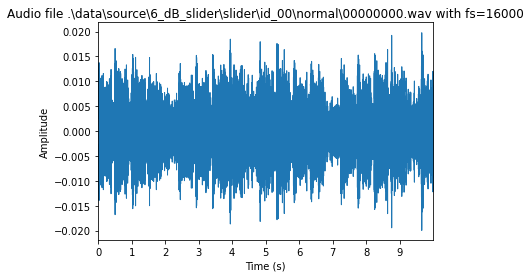

In [11]:
# Plot the signal
librosa.display.waveplot(signal, sr=fs)
plt.title(f"Audio file {file_path} with fs={fs}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

In [15]:
#Compute the FFT
sig_fft = np.fft.fft(signal)

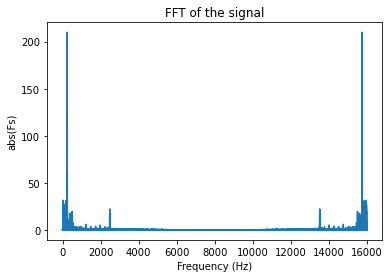

In [17]:
# Plot the FFT
frequency = np.linspace(0, fs, len(sig_fft))
plt.plot(frequency, abs(sig_fft))
plt.title("FFT of the signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("abs(Fs)")
plt.show()

In [25]:
help(librosa.core.stft)

Help on function stft in module librosa.core.spectrum:

stft(y, n_fft=2048, hop_length=None, win_length=None, window='hann', center=True, dtype=None, pad_mode='reflect')
    Short-time Fourier transform (STFT).
    
    The STFT represents a signal in the time-frequency domain by
    computing discrete Fourier transforms (DFT) over short overlapping
    windows.
    
    This function returns a complex-valued matrix D such that
    
    - ``np.abs(D[f, t])`` is the magnitude of frequency bin ``f``
      at frame ``t``, and
    
    - ``np.angle(D[f, t])`` is the phase of frequency bin ``f``
      at frame ``t``.
    
    The integers ``t`` and ``f`` can be converted to physical units by means
    of the utility functions `frames_to_sample` and `fft_frequencies`.
    
    
    Parameters
    ----------
    y : np.ndarray [shape=(n,)], real-valued
        input signal
    
    n_fft : int > 0 [scalar]
        length of the windowed signal after padding with zeros.
        The number of r

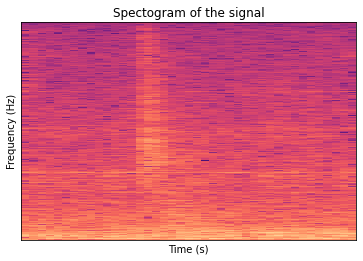

In [33]:
n_fft = 1*fs 
win_length = n_fft 
stft = librosa.core.stft(signal, win_length=win_length , n_fft=n_fft)   
signal_spect = abs(stft)

librosa.display.specshow(10*np.log10(signal_spect), sr=fs, hop_length=hop_length)
plt.title("Spectogram of the signal")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()

In [ ]:
mel_spect = librosa.feature.melspectrogram(y=signal, sr=fs, n_fft=2048, hop_length=1024)
mel_spect = librosa.power_to_db(spect, ref=np.max)
librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram');
plt.colorbar(format='%+2.0f dB');

In [36]:
help(librosa.feature.mfcc)

Help on function mfcc in module librosa.feature.spectral:

mfcc(y=None, sr=22050, S=None, n_mfcc=20, dct_type=2, norm='ortho', lifter=0, **kwargs)
    Mel-frequency cepstral coefficients (MFCCs)
    
    Parameters
    ----------
    y : np.ndarray [shape=(n,)] or None
        audio time series
    
    sr : number > 0 [scalar]
        sampling rate of ``y``
    
    S : np.ndarray [shape=(d, t)] or None
        log-power Mel spectrogram
    
    n_mfcc: int > 0 [scalar]
        number of MFCCs to return
    
    dct_type : {1, 2, 3}
        Discrete cosine transform (DCT) type.
        By default, DCT type-2 is used.
    
    norm : None or 'ortho'
        If ``dct_type`` is `2 or 3`, setting ``norm='ortho'`` uses an ortho-normal
        DCT basis.
    
        Normalization is not supported for ``dct_type=1``.
    
    lifter : number >= 0
        If ``lifter>0``, apply *liftering* (cepstral filtering) to the MFCCs::
    
            M[n, :] <- M[n, :] * (1 + sin(pi * (n + 1) / lifte

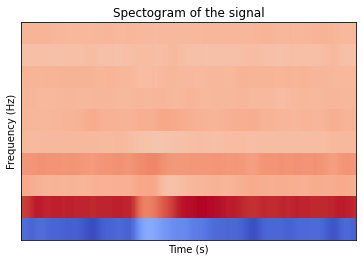

In [35]:
n_fft = 1*fs 
win_length = n_fft 
mfcc = librosa.feature.mfcc(signal, n_fft=n_fft, win_length=win_length, n_mfcc=10)

librosa.display.specshow(mfcc, sr=fs, hop_length=hop_length)
plt.title("Spectogram of the signal")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()